In [55]:
%autosave 30
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import csv
%matplotlib inline

Autosaving every 30 seconds


<b/> Read in all the CSVs, add identifying columns, append

In [116]:
df = pd.DataFrame()
#dfF = pd.DataFrame()

for i in range(10,18):
    
    m = pd.read_csv("LonM20{}.csv".format(i), encoding='latin1')
    f = pd.read_csv("LonF20{}.csv".format(i), encoding='latin1')
    m['Year'] = '20{}'.format(i)
    m['Sex'] = 'M'
    f['Year'] = '20{}'.format(i)
    f['Sex'] = 'F'
    
    df = df.append(f,ignore_index=False)
    df = df.append(m,ignore_index=False)
    


In [117]:
df.columns

Index(['Category', 'Club', 'Finish', 'Half', 'J', 'Name', 'Place Category',
       'Place Gender', 'Place Overall', 'Runner No', 'Sex', 'Unnamed: 0',
       'Year'],
      dtype='object')

<b/> Data preparation

In [118]:
#remove duplicates
df.drop_duplicates()

#remove repeated instances of header
df = df[df.Category != "Category"]
df = df[df.Category != "Runner No"]

#drop uneccessary columns
df.drop(df.columns[[4,11]], axis=1, inplace=True)


# tidy up columns by removing first and last character
df['Name'] = df['Name'].map(lambda x: str(x)[:-1])
df['Name'] = df['Name'].map(lambda x: str(x)[1:])

# convert to necessary formats
df['Finish'] = pd.to_timedelta(df['Finish'], errors='coerce')
df['Half'] = pd.to_timedelta(df['Half'], errors='coerce')

df['Place Category'] = pd.to_numeric(df['Place Category'], errors='coerce')
df['Place Gender'] = pd.to_numeric(df['Place Gender'], errors='coerce')
df['Place Overall'] = pd.to_numeric(df['Place Overall'], errors='coerce')


# Find duration of second half
df['Diff'] = df['Finish'] - df['Half']


#find difference between first and second halfs
df['Diff2'] = abs((df['Diff'] - df['Half']))


# rename columns
df.rename(columns = {'Half':'First Half', 'Diff':'Second Half', 'Diff2':'Difference'}, inplace = True)

# reorder columns
df = df[['First Half', 'Second Half', 'Difference', 'Finish', 'Category', 'Place Overall', 'Place Category', 'Place Gender', 'Name', 'Club', 'Runner No', 'Year', 'Sex']]

#create a new column with a default value
df['Splits'] = np.nan

# add values based on first and second half times
df.loc[df['First Half'] > df['Second Half'], 'Splits'] = 'Positive'
df.loc[df['First Half'] < df['Second Half'], 'Splits'] = 'Negative'

# convert time columns to seconds only so we can calculate averages
df['1st seconds'] = df['First Half'] / np.timedelta64(1, 's')
df['2nd seconds'] = df['Second Half'] / np.timedelta64(1, 's')
df['Finish seconds'] = df['Finish'] / np.timedelta64(1, 's')
df['Diff seconds'] = df['Difference'] / np.timedelta64(1, 's')



#create copies to create graphs from

# Finishers copy
Finishers = df[['Category', '1st seconds', '2nd seconds', 'Finish seconds', 'Diff seconds', 'Splits', 'Year', 'Sex']]
Finishers.dropna(axis=0, how='any', inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [99]:
Finishers.count()

Category          307712
1st seconds       307712
2nd seconds       307712
Finish seconds    307712
Diff seconds      307712
Splits            307712
Year              307712
Sex               307712
dtype: int64

In [234]:
pd.pivot_table(Finishers,index=["Category","Sex"],values=["Finish seconds", "1st seconds", "2nd seconds"],aggfunc=[np.mean, np.median])

mean                                   median  \
              1st seconds   2nd seconds Finish seconds 1st seconds   
Category Sex                                                         
18-39    F    8159.296201   9311.329385   17484.639039      8084.0   
         M    7097.101737   8374.376957   15478.360456      7060.0   
40-44    F    8033.424575   9026.185668   17067.111495      7934.0   
         M    6991.281130   8066.035474   15061.542600      6939.0   
45-49    F    8082.032912   9119.120611   17218.170743      7971.0   
         M    7049.341976   8137.559481   15189.499048      6976.0   
50-54    F    8217.599282   9307.742438   17545.113476      8051.0   
         M    7199.596821   8332.370901   15536.877805      7079.5   
55-59    F    8442.312012   9596.933092   18060.460174      8270.5   
         M    7495.828107   8760.872909   16256.771917      7337.0   
60-64    F    8710.533844   9925.884837   18675.015903      8504.5   
         M    7774.604244   9098.584370   16879.193956      7577.5   
65-69    F    9014.676174  10305.991582   19372.873122      8753.5   
         M    8088.807731   9449.882624   17591.975585      7811.0   
70+      F    9629.320755  11062.828571   20677.839117      9550.0   
         M    8754.725557  10313.182526   19160.060580      8372.5   

                                         
             2nd seconds Finish seconds  
Category Sex                             
18-39    F        9089.0        17228.0  
         M        8159.0        15261.0  
40-44    F        8780.0        16751.0  
         M        7801.0        14751.0  
45-49    F        8896.0        16899.0  
         M        7860.0        14847.0  
50-54    F        9049.0        17145.0  
         M        8017.5        15149.5  
55-59    F        9405.5        17755.0  
         M        8538.0        15949.0  
60-64    F        9754.0        18283.0  
         M        8865.0        16486.0  
65-69    F       10183.0        18946.0  
         M        9206.0        17086.0  
70+      F       11135.0        20794.0  
         M       10082.0        18455.5

In [211]:
pd.pivot_table(Finishers,index=["Sex", "Year"],values=["Finish seconds", "Diff seconds"],aggfunc=[np.mean])



mean               
         Diff seconds Finish seconds
Sex Year                            
F   2010   507.896376   13812.830174
    2011  1270.832302   17956.627937
    2012  1198.930117   17637.968447
    2013  1207.124216   17628.616799
    2014  1184.445785   17525.009843
    2015  1019.367522   17118.317844
    2016  1009.422212   17317.169280
    2017  1104.646414   17228.388278
M   2010  1223.196501   15510.558291
    2011  1440.054756   16030.400393
    2012  1330.241958   15759.468272
    2013  1314.874634   15609.873629
    2014  1271.499637   15537.260805
    2015  1010.838581   15072.550127
    2016  1034.103176   15147.178840
    2017  1174.859796   15195.937663

In [280]:
Finishers['COUNTER'] =1       #initially, set that counter to 1.
group_data = Finishers.groupby(['Category','Splits'])['COUNTER'].sum() #sum function
print(group_data)

Category  Splits  
18-39     Negative    161737
          Positive      9057
40-44     Negative     49763
          Positive      2810
45-49     Negative     37218
          Positive      1852
50-54     Negative     23222
          Positive      1009
55-59     Negative     10833
          Positive       374
60-64     Negative      5677
          Positive       145
65-69     Negative      2469
          Positive        76
70+       Negative      1435
          Positive        35
Name: COUNTER, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [281]:
# expressing groupby as percentages
group_data.groupby(level=[0]).apply(lambda x: x / x.sum())

Category  Splits  
18-39     Negative    0.946971
          Positive    0.053029
40-44     Negative    0.946551
          Positive    0.053449
45-49     Negative    0.952598
          Positive    0.047402
50-54     Negative    0.958359
          Positive    0.041641
55-59     Negative    0.966628
          Positive    0.033372
60-64     Negative    0.975094
          Positive    0.024906
65-69     Negative    0.970138
          Positive    0.029862
70+       Negative    0.976190
          Positive    0.023810
Name: COUNTER, dtype: float64

<b/> If we need to see unique values in a column

In [255]:
Finishers['Category'].unique()

array(['18-39', '40-44', '50-54', '45-49', '55-59', '60-64', '65-69',
       '70+', nan], dtype=object)

<b/> Let's explore our data. First let's count how many are in each age group

In [282]:
AgeGroup = (df.groupby(['Category', 'Year']).agg({'Name': 'count'})
          .sort_values(by='Name', ascending=False))[:20].reset_index()

SexGroup = (df.groupby(['Sex', 'Year']).agg({'Name': 'count'})
          .sort_values(by='Name', ascending=False))[:20].reset_index()

SexGroup.head(20)

,Sex,Year,Name
0,M,2016,28634
1,M,2012,28394
2,M,2015,27874
3,M,2011,27308
4,M,2014,27028
5,M,2013,26476
6,M,2010,25467
7,M,2017,24961
8,F,2016,18572
9,F,2015,17872


In [19]:
ClubGroup = (df.groupby('Club').agg({'Name': 'count'})
          .sort_values(by='Name', ascending=False))[:10].reset_index()

ClubGroup

,Club,Name
0,None,136
1,Serpenti...,51
2,Clapham ...,48
3,none,48
4,Cambridge...,41
5,Victoria P...,38
6,Reading ...,33
7,South Lo...,29
8,Serpentine,29
9,Wimbledon ...,29


<b/> If you need to filter

In [3]:
Finishers[Finishers["Splits"]=="NaN"].head()

,Category,1st seconds,2nd seconds,Finish seconds,Diff seconds,Splits


In [28]:
df.head(2)

,First Half,Second Half,Difference,Finish,Category,Place Overall,Place Category,Place Gender,Name,Club,Runner No,Splits,1st seconds,2nd seconds,Finish seconds,Diff seconds
0,01:47:59,01:59:59,00:12:00,03:47:58,18-39,10490.0,4116.0,8351.0,"17, Juan Cascales (GBR)",NaN,6088,Negative,6479.0,7199.0,13678.0,720.0
1,01:46:23,02:07:26,00:21:03,03:53:49,18-39,12114.0,4674.0,9451.0,"A'Court, Oliver (GBR)",NaN,5713,Negative,6383.0,7646.0,14029.0,1263.0


<b/> Playing with graphs in Seaborn

(0, 25000)

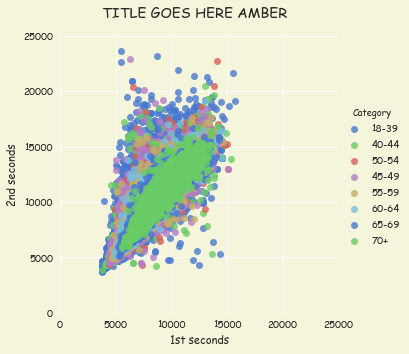

In [326]:
# no regression line (it is automatic otherwise as there is no scatterplot function)
# colour based on age category

sns.set(style='darkgrid', font='fantasy', rc={'axes.facecolor':'beige', 'figure.facecolor':'beige'})
g=sns.lmplot(x='1st seconds', y='2nd seconds', data=Finishers, fit_reg=False, hue='Category',palette="muted")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('TITLE GOES HERE AMBER')

# we need to use matplotlib functions to set the axes boundaries
plt.ylim(0, 25000)
plt.xlim(0, 25000)

(0, 38803.849999999999)

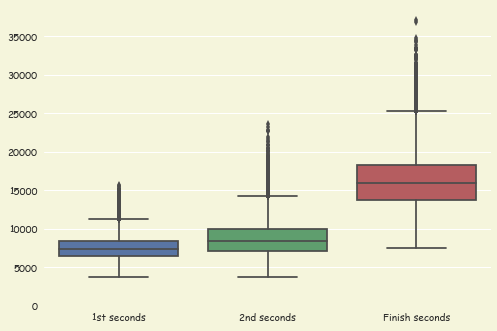

In [316]:
# Pre-format a new DataFrame
stats_df = Finishers[['1st seconds','2nd seconds', 'Finish seconds']]
 
# New boxplot using stats_df
sns.boxplot(data=stats_df)

# we need to use matplotlib functions to set the axes boundaries
plt.ylim(0, None)


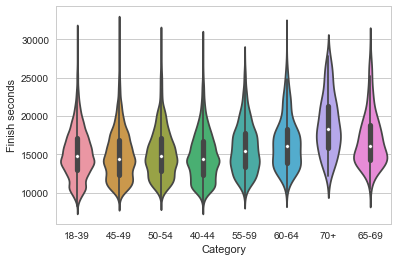

In [42]:
# Set theme
sns.set_style('whitegrid')
 
# Violin plot
sns.violinplot(x='Category', y='Finish seconds', data=df)

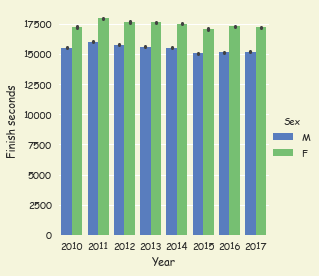

In [317]:
# Set up a factorplot
g = sns.factorplot("Year", "Finish seconds", "Sex", data=Finishers, kind="bar", palette="muted", legend=True)
                   
# Show plot
plt.show()

In [136]:
# Pre-format a new DataFrame
ff = Finishers[Finishers['Year'] == '2017']

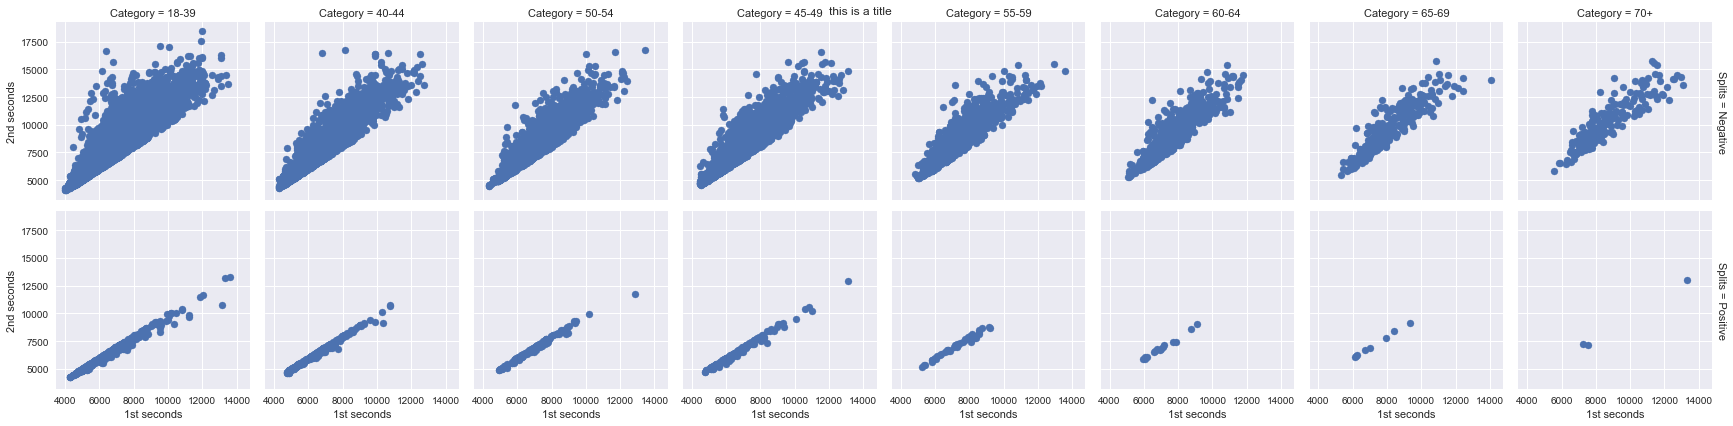

In [154]:
g = sns.FacetGrid(ff, col="Category", row="Splits", margin_titles=True)
g.map(sns.plt.scatter, "1st seconds", "2nd seconds")

# Add a title to the figure
g.fig.suptitle("this is a title")

# Show the plot
plt.show()

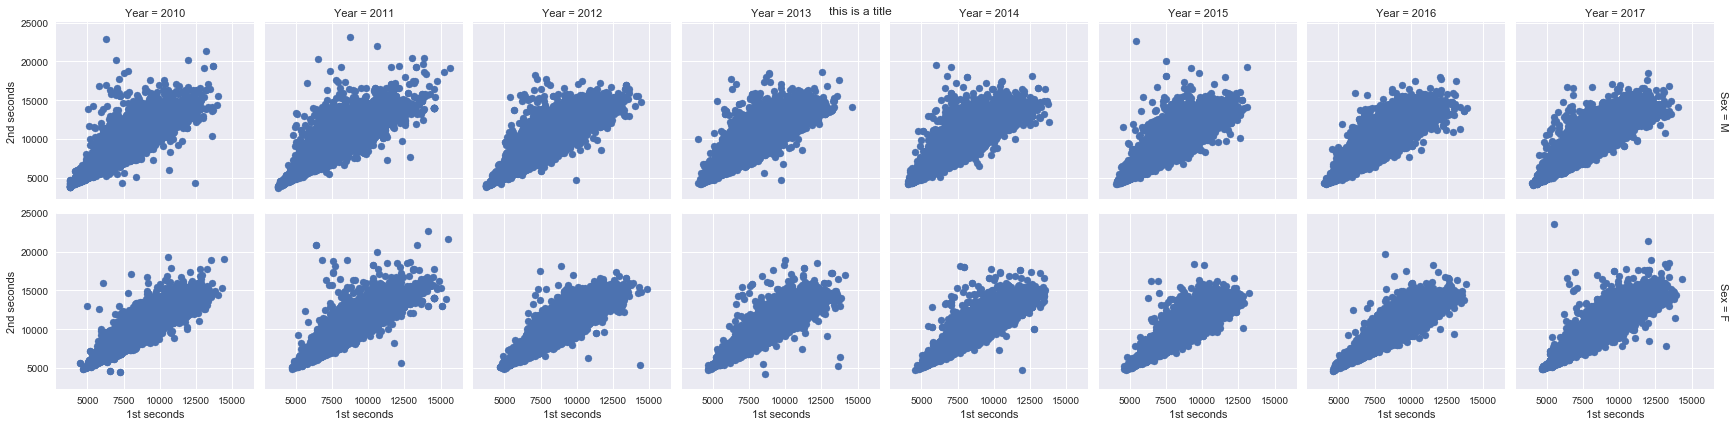

In [270]:
g = sns.FacetGrid(Finishers, col="Year", row= "Sex", margin_titles=True)
g.map(sns.plt.scatter, "1st seconds", "2nd seconds")

# Add a title to the figure
g.fig.suptitle("this is a title")

# Show the plot
plt.show()

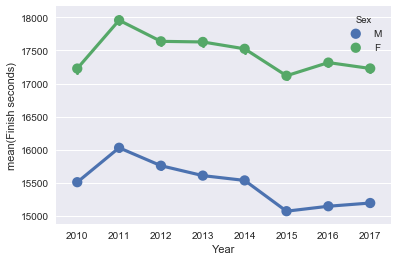

In [271]:
sns.pointplot(x="Year", y="Finish seconds", hue="Sex", data=Finishers);

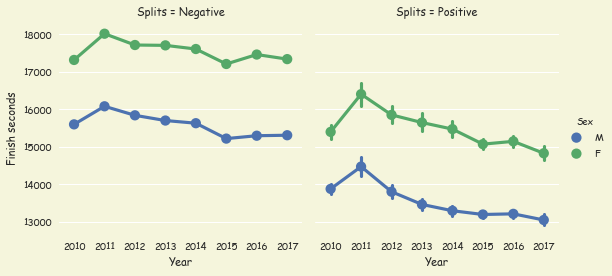

In [319]:
sns.factorplot(data=Finishers, x="Year", y="Finish seconds", col="Splits", hue="Sex")

# Add a title to the figure
g.fig.suptitle("this is a title")

# Show the plot
plt.show()

In [162]:
Finishers.head()

,Category,1st seconds,2nd seconds,Finish seconds,Diff seconds,Splits,Year
0,18-39,4000.0,4089.0,8089.0,89.0,Negative,2017
1,18-39,4027.0,4151.0,8178.0,124.0,Negative,2017
2,18-39,3998.0,4267.0,8265.0,269.0,Negative,2017
3,18-39,4027.0,4239.0,8266.0,212.0,Negative,2017
4,18-39,4113.0,4165.0,8278.0,52.0,Negative,2017


<b/> Use a factorplot to specify a number of different kinds of charts

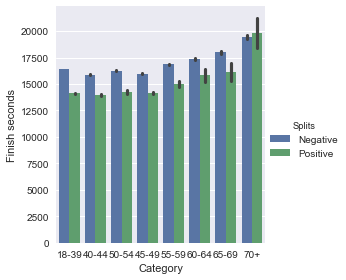

In [273]:
sns.factorplot(x="Category", y="Finish seconds", hue="Splits", data=Finishers, kind="bar");

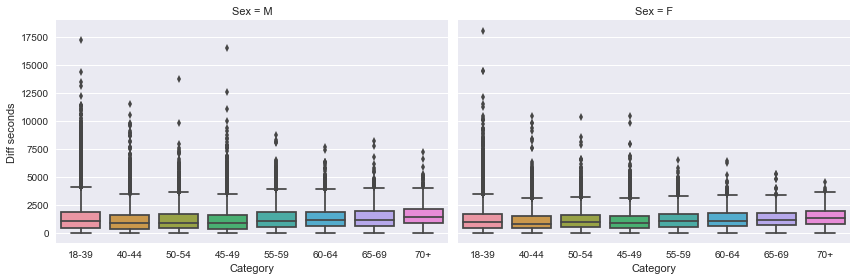

In [274]:
sns.factorplot(x="Category", y="Diff seconds",
               col="Sex", data=Finishers, kind="box", size=4, aspect=1.5);

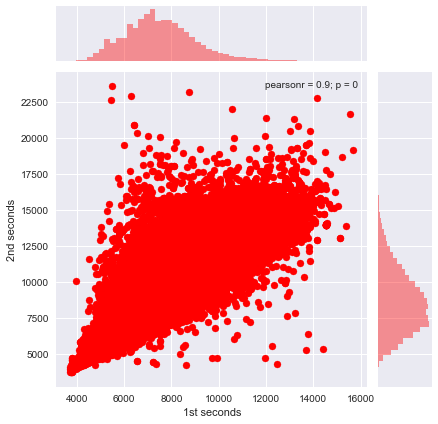

In [247]:
sns.jointplot(x="1st seconds", y="2nd seconds", data=Finishers, color='r');

(0, 15000)

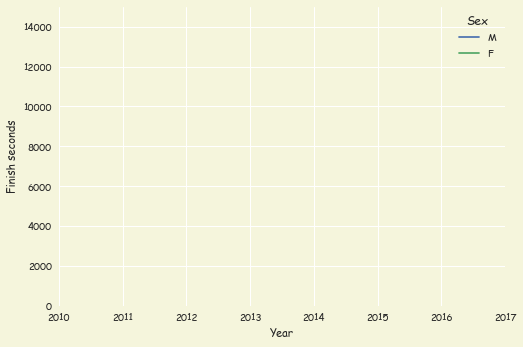

In [315]:
ax = sns.tsplot(time="Year", value="Finish seconds",
                condition="Sex",
                data=Finishers)

# we need to use matplotlib functions to set the axes boundaries
plt.ylim(0, 15000)